In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.transform import Rotation as R
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np

In [78]:
columns_list = (
    [f'{axis}_world_{i}' for i in range(21) for axis in ['x', 'y', 'z']] +       # absolute position
    [f'{axis}_world_{i}_rel' for i in range(21) for axis in ['x', 'y', 'z']] +   # relative
    ['HeadsetPosX', 'HeadsetPosY', 'HeadsetPosZ',
     'HeadsetRotX', 'HeadsetRotY', 'HeadsetRotZ', 'HeadsetRotW'] +              # headset
    ['dist_0_4', 'dist_0_8', 'dist_4_8', 'dist_8_12',
     'angle_wrist_index_z', 'angle_wrist_thumb_z',
     'x_world_0_delta', 'y_world_0_delta', 'z_world_0_delta',
     'x_world_0_speed', 'y_world_0_speed', 'z_world_0_speed',
     'z_world_0_speed_mean9', 'z_world_0_accel'] +                               # engineered
    ['x_pair_0_4_headnorm', 'y_pair_0_4_headnorm', 'z_pair_0_4_headnorm',
     'dist_0_4_headnorm',
     'vec_x_speed', 'vec_y_speed', 'vec_z_speed']                                # headnorm
)

X = df_train[columns_list].copy()

y = df_train[['ControllerPosX', 'ControllerPosY', 'ControllerPosZ']].copy()

mask_not_nan = ~y.isnull().any(axis=1)

# Filter X และ y
X_clean = X.loc[mask_not_nan].reset_index(drop=True)
y_clean = y.loc[mask_not_nan].reset_index(drop=True)

print(f'X_clean shape: {X_clean.shape}')
print(f'y_clean shape: {y_clean.shape}')
print(f'Removed rows: {len(X) - len(X_clean)}')

X_clean shape: (19510, 154)
y_clean shape: (19510, 3)
Removed rows: 602


In [79]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list = []

for train_index, test_index in kf.split(X_clean):
    X_train, X_test = X_clean.iloc[train_index], X_clean.iloc[test_index]
    y_train, y_test = y_clean.iloc[train_index], y_clean.iloc[test_index]

    # Fit RF
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_list.append(rmse)

print("RMSE Scores (each fold):", np.round(rmse_list, 5))
print("Mean RMSE:", np.mean(rmse_list))
print("Std Dev RMSE:", np.std(rmse_list))

RMSE Scores (each fold): [0.01084 0.00996 0.00997 0.01048 0.01023]
Mean RMSE: 0.01029469542462252
Std Dev RMSE: 0.00033337259392300287


In [80]:
y_pred = pd.DataFrame(y_pred, columns=['Pred_X', 'Pred_Y', 'Pred_Z'])  # แปลง array → DataFrame

y_test.columns = ['GT_X', 'GT_Y', 'GT_Z']
y_pred.columns = ['Pred_X', 'Pred_Y', 'Pred_Z']

residuals = y_pred.values - y_test.values
residuals_df = pd.DataFrame(residuals, columns=['Residual_X', 'Residual_Y', 'Residual_Z'])

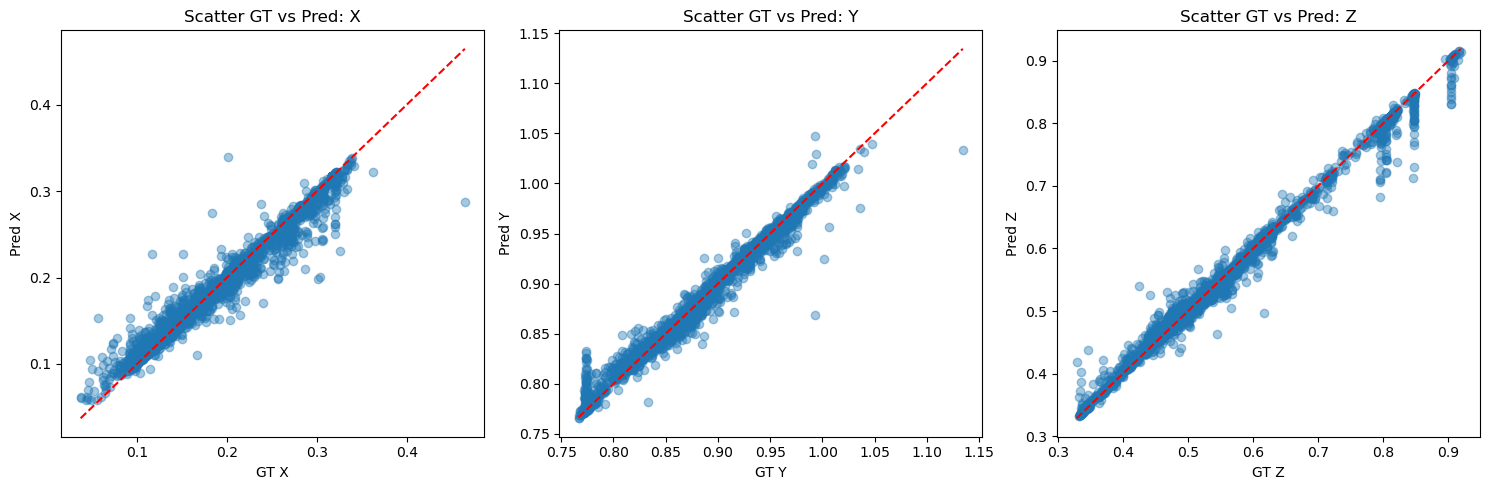

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, axis in enumerate(['X', 'Y', 'Z']):
    axes[i].scatter(y_test[f'GT_{axis}'], y_pred[f'Pred_{axis}'], alpha=0.4)
    axes[i].plot([y_test[f'GT_{axis}'].min(), y_test[f'GT_{axis}'].max()],
                 [y_test[f'GT_{axis}'].min(), y_test[f'GT_{axis}'].max()], 'r--')
    axes[i].set_title(f'Scatter GT vs Pred: {axis}')
    axes[i].set_xlabel(f'GT {axis}')
    axes[i].set_ylabel(f'Pred {axis}')
plt.tight_layout()
plt.show()

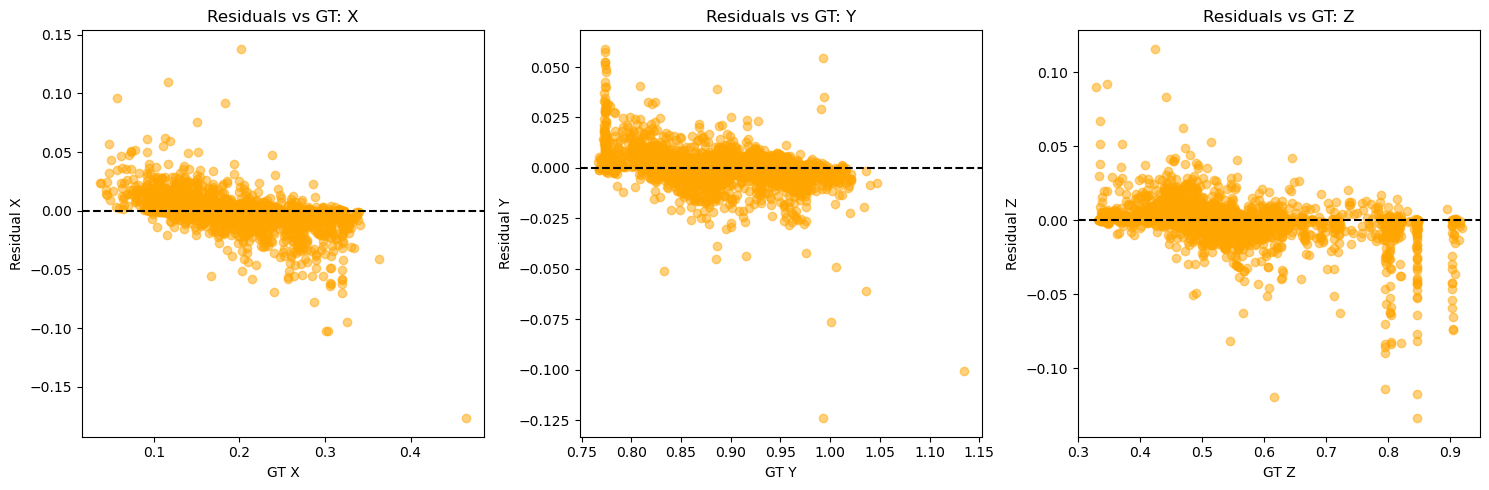

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, axis in enumerate(['X', 'Y', 'Z']):
    axes[i].scatter(y_test[f'GT_{axis}'], residuals_df[f'Residual_{axis}'], color='orange', alpha=0.5)
    axes[i].axhline(0, linestyle='--', color='black')
    axes[i].set_title(f'Residuals vs GT: {axis}')
    axes[i].set_xlabel(f'GT {axis}')
    axes[i].set_ylabel(f'Residual {axis}')
plt.tight_layout()
plt.show()

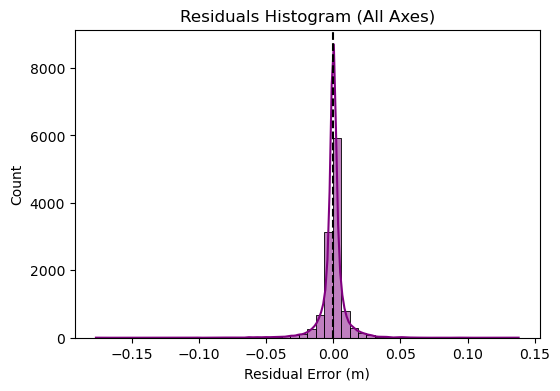

In [83]:
residuals_all = residuals_df.values.flatten()

plt.figure(figsize=(6, 4))
sns.histplot(residuals_all, bins=50, kde=True, color='purple')
plt.axvline(0, linestyle='--', color='black')
plt.title("Residuals Histogram (All Axes)")
plt.xlabel("Residual Error (m)")
plt.show()

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_31387/4178589430.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(top_n), y='Feature', x='Importance', palette='viridis')


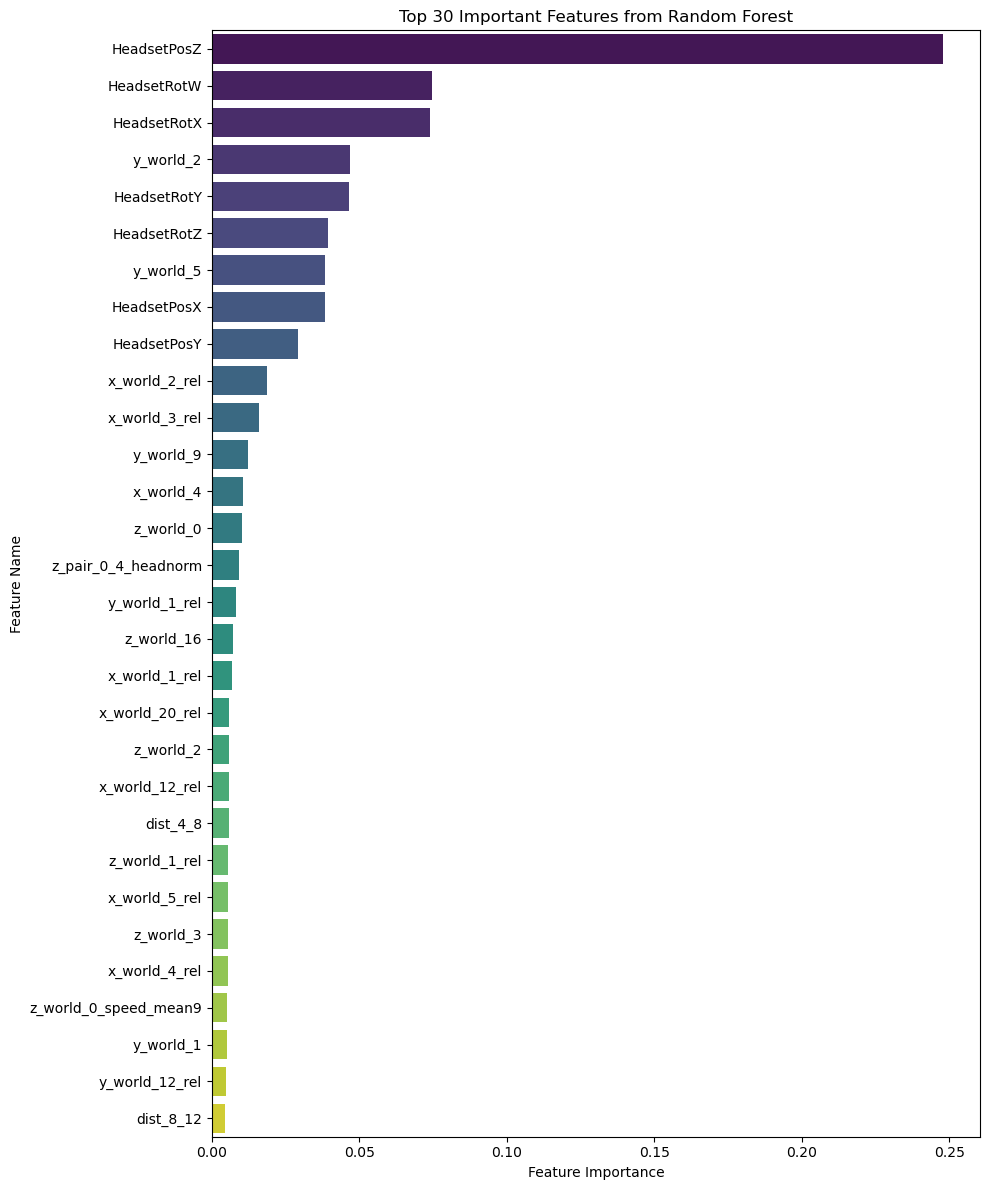

In [85]:
feature_importance = pd.DataFrame({
    'Feature': X_clean.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_n = 30
plt.figure(figsize=(10, 12))
sns.barplot(data=feature_importance.head(top_n), y='Feature', x='Importance', palette='viridis')
plt.title(f'Top {top_n} Important Features from Random Forest')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

In [86]:
print(feature_importance.to_string())

                   Feature  Importance
128            HeadsetPosZ    0.247987
132            HeadsetRotW    0.074551
129            HeadsetRotX    0.073823
7                y_world_2    0.046882
130            HeadsetRotY    0.046315
131            HeadsetRotZ    0.039464
16               y_world_5    0.038284
126            HeadsetPosX    0.038140
127            HeadsetPosY    0.029241
69           x_world_2_rel    0.018753
72           x_world_3_rel    0.016022
28               y_world_9    0.012209
12               x_world_4    0.010356
2                z_world_0    0.010042
149    z_pair_0_4_headnorm    0.009239
67           y_world_1_rel    0.008115
50              z_world_16    0.007170
66           x_world_1_rel    0.006727
123         x_world_20_rel    0.005867
8                z_world_2    0.005667
99          x_world_12_rel    0.005667
135               dist_4_8    0.005596
68           z_world_1_rel    0.005530
78           x_world_5_rel    0.005502
11               z_world_

In [89]:
columns_list = (
    ['HeadsetPosX', 'HeadsetPosY', 'HeadsetPosZ',
     'HeadsetRotX', 'HeadsetRotY', 'HeadsetRotZ', 'HeadsetRotW'])

X = df_train[columns_list].copy()

y = df_train[['ControllerPosX', 'ControllerPosY', 'ControllerPosZ']].copy()

mask_not_nan = ~y.isnull().any(axis=1)

# Filter X และ y
X_clean = X.loc[mask_not_nan].reset_index(drop=True)
y_clean = y.loc[mask_not_nan].reset_index(drop=True)

print(f'X_clean shape: {X_clean.shape}')
print(f'y_clean shape: {y_clean.shape}')
print(f'Removed rows: {len(X) - len(X_clean)}')

X_clean shape: (19510, 7)
y_clean shape: (19510, 3)
Removed rows: 602


In [90]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list = []

for train_index, test_index in kf.split(X_clean):
    X_train, X_test = X_clean.iloc[train_index], X_clean.iloc[test_index]
    y_train, y_test = y_clean.iloc[train_index], y_clean.iloc[test_index]

    # Fit RF
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_list.append(rmse)

print("RMSE Scores (each fold):", np.round(rmse_list, 5))
print("Mean RMSE:", np.mean(rmse_list))
print("Std Dev RMSE:", np.std(rmse_list))

RMSE Scores (each fold): [0.00905 0.00768 0.00926 0.00837 0.00814]
Mean RMSE: 0.008497304997405766
Std Dev RMSE: 0.0005854239527243651


In [91]:
y_pred = pd.DataFrame(y_pred, columns=['Pred_X', 'Pred_Y', 'Pred_Z']) 

y_test.columns = ['GT_X', 'GT_Y', 'GT_Z']
y_pred.columns = ['Pred_X', 'Pred_Y', 'Pred_Z']

residuals = y_pred.values - y_test.values
residuals_df = pd.DataFrame(residuals, columns=['Residual_X', 'Residual_Y', 'Residual_Z'])

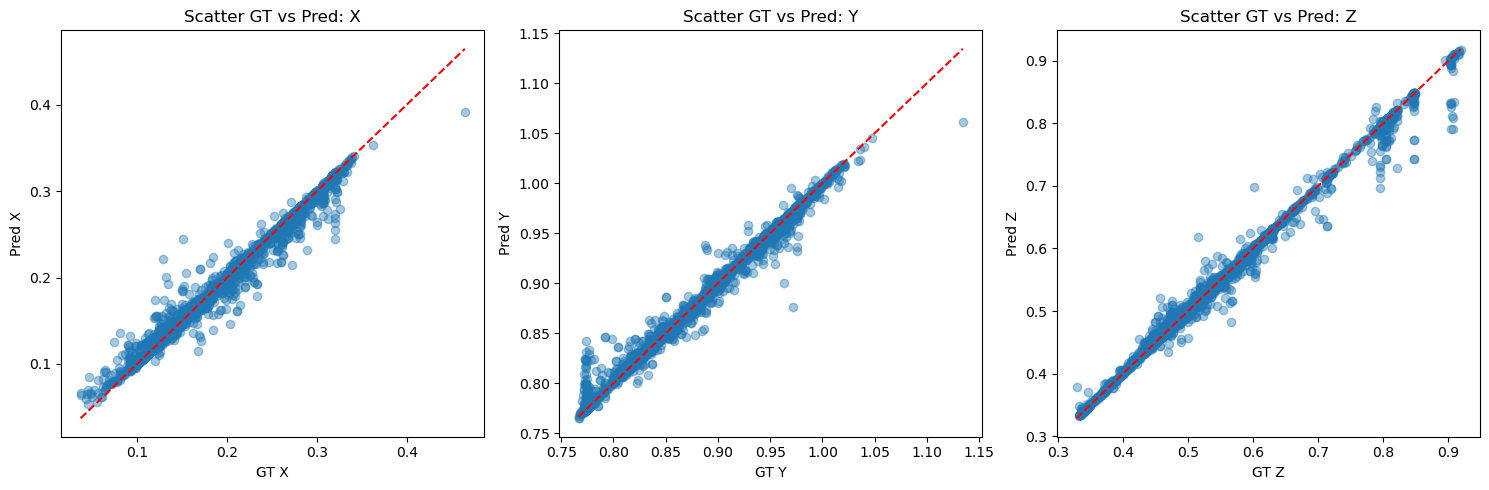

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, axis in enumerate(['X', 'Y', 'Z']):
    axes[i].scatter(y_test[f'GT_{axis}'], y_pred[f'Pred_{axis}'], alpha=0.4)
    axes[i].plot([y_test[f'GT_{axis}'].min(), y_test[f'GT_{axis}'].max()],
                 [y_test[f'GT_{axis}'].min(), y_test[f'GT_{axis}'].max()], 'r--')
    axes[i].set_title(f'Scatter GT vs Pred: {axis}')
    axes[i].set_xlabel(f'GT {axis}')
    axes[i].set_ylabel(f'Pred {axis}')
plt.tight_layout()
plt.show()

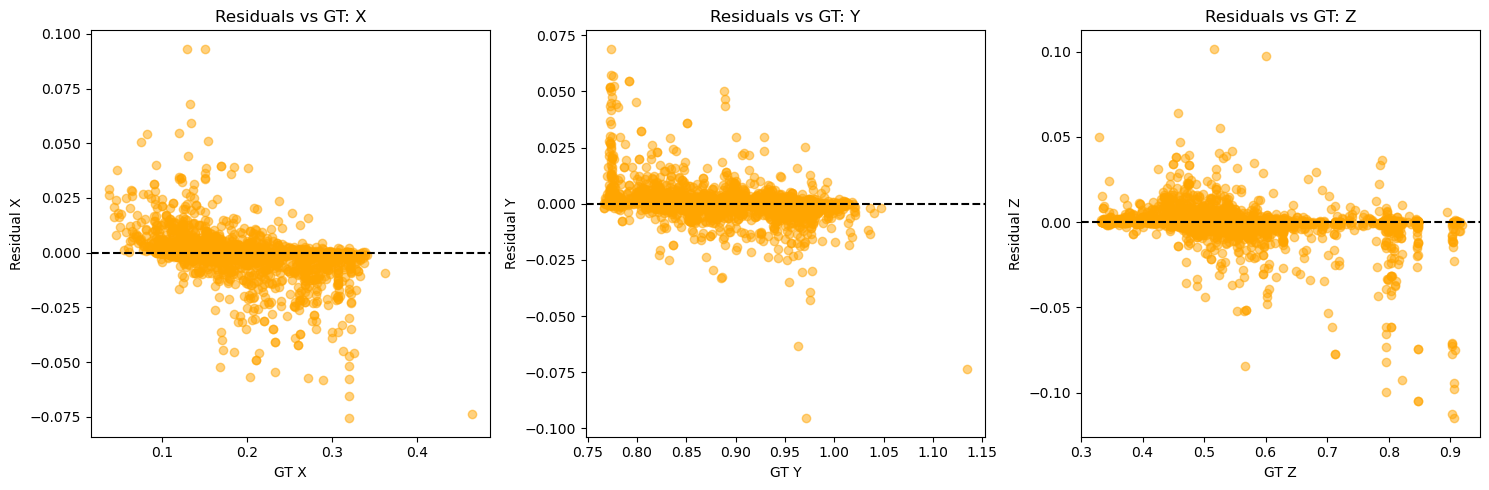

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, axis in enumerate(['X', 'Y', 'Z']):
    axes[i].scatter(y_test[f'GT_{axis}'], residuals_df[f'Residual_{axis}'], color='orange', alpha=0.5)
    axes[i].axhline(0, linestyle='--', color='black')
    axes[i].set_title(f'Residuals vs GT: {axis}')
    axes[i].set_xlabel(f'GT {axis}')
    axes[i].set_ylabel(f'Residual {axis}')
plt.tight_layout()
plt.show()

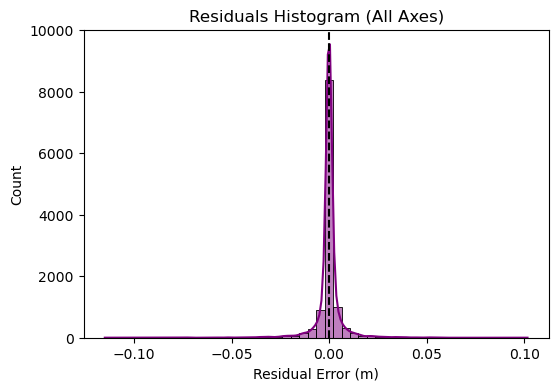

In [94]:
residuals_all = residuals_df.values.flatten()

plt.figure(figsize=(6, 4))
sns.histplot(residuals_all, bins=50, kde=True, color='purple')
plt.axvline(0, linestyle='--', color='black')
plt.title("Residuals Histogram (All Axes)")
plt.xlabel("Residual Error (m)")
plt.show()

In [96]:
columns_list = (
    [f'{axis}_world_{i}' for i in range(21) for axis in ['x', 'y', 'z']] +       # absolute position
    [f'{axis}_world_{i}_rel' for i in range(21) for axis in ['x', 'y', 'z']] +   # relative
    ['dist_0_4', 'dist_0_8', 'dist_4_8', 'dist_8_12',
     'angle_wrist_index_z', 'angle_wrist_thumb_z',
     'x_world_0_delta', 'y_world_0_delta', 'z_world_0_delta',
     'x_world_0_speed', 'y_world_0_speed', 'z_world_0_speed',
     'z_world_0_speed_mean9', 'z_world_0_accel'] +                               # engineered
    ['x_pair_0_4_headnorm', 'y_pair_0_4_headnorm', 'z_pair_0_4_headnorm',
     'dist_0_4_headnorm',
     'vec_x_speed', 'vec_y_speed', 'vec_z_speed']                                # headnorm
)

X = df_train[columns_list].copy()

y = df_train[['ControllerPosX', 'ControllerPosY', 'ControllerPosZ']].copy()

mask_not_nan = ~y.isnull().any(axis=1)

# Filter X และ y
X_clean = X.loc[mask_not_nan].reset_index(drop=True)
y_clean = y.loc[mask_not_nan].reset_index(drop=True)

print(f'X_clean shape: {X_clean.shape}')
print(f'y_clean shape: {y_clean.shape}')
print(f'Removed rows: {len(X) - len(X_clean)}')

X_clean shape: (19510, 147)
y_clean shape: (19510, 3)
Removed rows: 602


In [97]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list = []

for train_index, test_index in kf.split(X_clean):
    X_train, X_test = X_clean.iloc[train_index], X_clean.iloc[test_index]
    y_train, y_test = y_clean.iloc[train_index], y_clean.iloc[test_index]

    # Fit RF
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmse_list.append(rmse)

print("RMSE Scores (each fold):", np.round(rmse_list, 5))
print("Mean RMSE:", np.mean(rmse_list))
print("Std Dev RMSE:", np.std(rmse_list))

RMSE Scores (each fold): [0.01661 0.01697 0.01625 0.01635 0.0171 ]
Mean RMSE: 0.016656628570583573
Std Dev RMSE: 0.0003343040134373284


/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_31387/3917293397.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(top_n), y='Feature', x='Importance', palette='viridis')


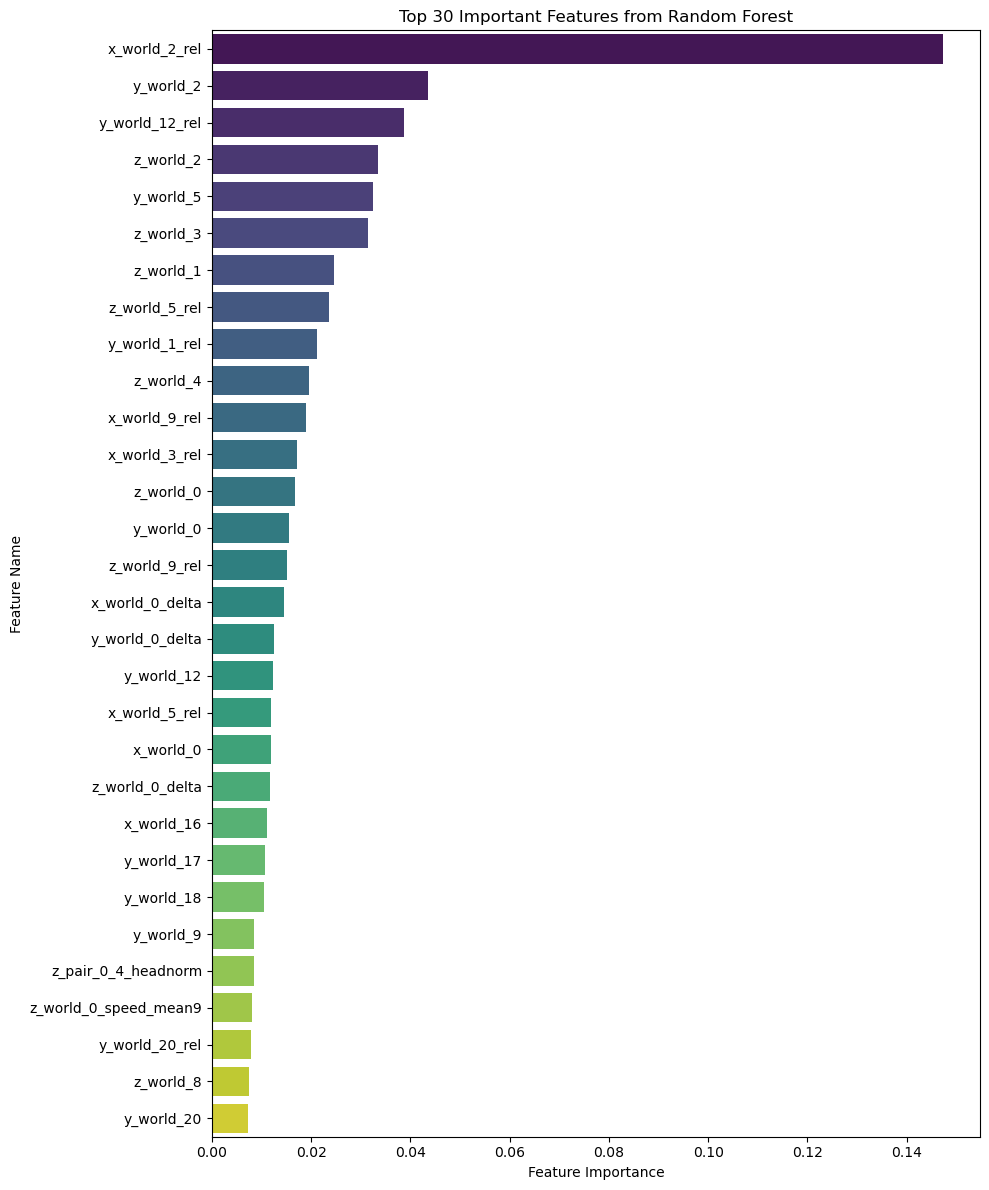

In [98]:
feature_importance = pd.DataFrame({
    'Feature': X_clean.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

top_n = 30
plt.figure(figsize=(10, 12))
sns.barplot(data=feature_importance.head(top_n), y='Feature', x='Importance', palette='viridis')
plt.title(f'Top {top_n} Important Features from Random Forest')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

In [556]:
print(feature_importance.to_string())

                   Feature  Importance
69           x_world_2_rel    0.147417
7                y_world_2    0.043595
100         y_world_12_rel    0.038629
8                z_world_2    0.033494
16               y_world_5    0.032493
11               z_world_3    0.031351
5                z_world_1    0.024589
80           z_world_5_rel    0.023569
67           y_world_1_rel    0.021187
14               z_world_4    0.019506
90           x_world_9_rel    0.018867
72           x_world_3_rel    0.017135
2                z_world_0    0.016820
1                y_world_0    0.015488
92           z_world_9_rel    0.015155
132        x_world_0_delta    0.014572
133        y_world_0_delta    0.012428
37              y_world_12    0.012197
78           x_world_5_rel    0.011975
0                x_world_0    0.011862
134        z_world_0_delta    0.011693
48              x_world_16    0.011050
52              y_world_17    0.010605
55              y_world_18    0.010507
28               y_world_

In [99]:
y_pred = pd.DataFrame(y_pred, columns=['Pred_X', 'Pred_Y', 'Pred_Z'])  # แปลง array → DataFrame

y_test.columns = ['GT_X', 'GT_Y', 'GT_Z']
y_pred.columns = ['Pred_X', 'Pred_Y', 'Pred_Z']

residuals = y_pred.values - y_test.values
residuals_df = pd.DataFrame(residuals, columns=['Residual_X', 'Residual_Y', 'Residual_Z'])

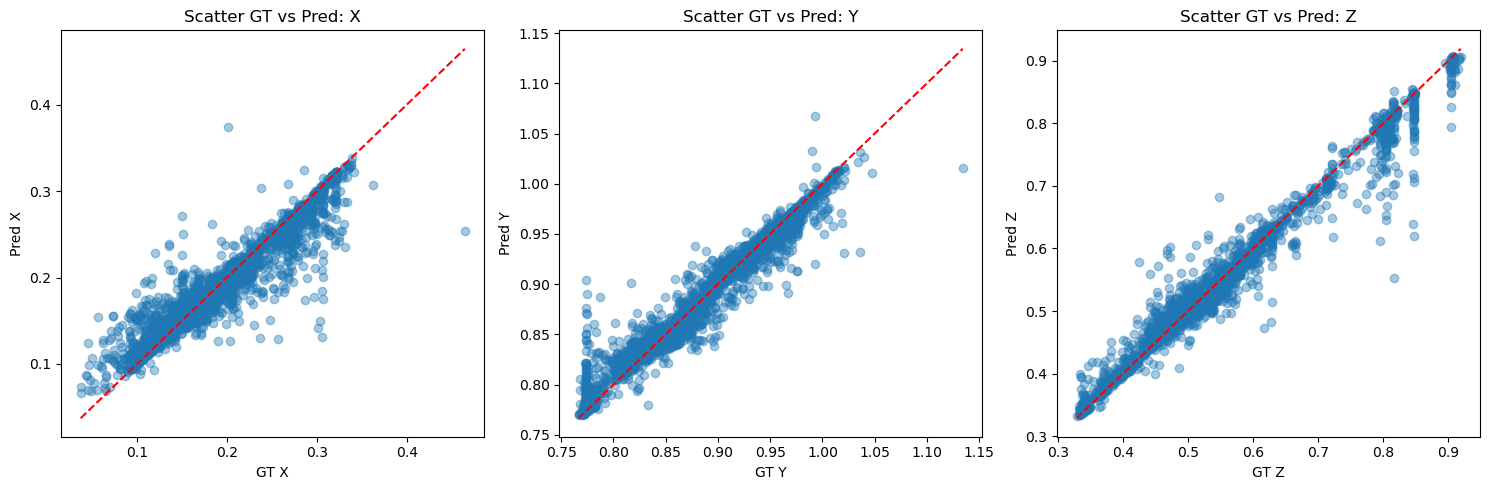

In [100]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, axis in enumerate(['X', 'Y', 'Z']):
    axes[i].scatter(y_test[f'GT_{axis}'], y_pred[f'Pred_{axis}'], alpha=0.4)
    axes[i].plot([y_test[f'GT_{axis}'].min(), y_test[f'GT_{axis}'].max()],
                 [y_test[f'GT_{axis}'].min(), y_test[f'GT_{axis}'].max()], 'r--')
    axes[i].set_title(f'Scatter GT vs Pred: {axis}')
    axes[i].set_xlabel(f'GT {axis}')
    axes[i].set_ylabel(f'Pred {axis}')
plt.tight_layout()
plt.show()

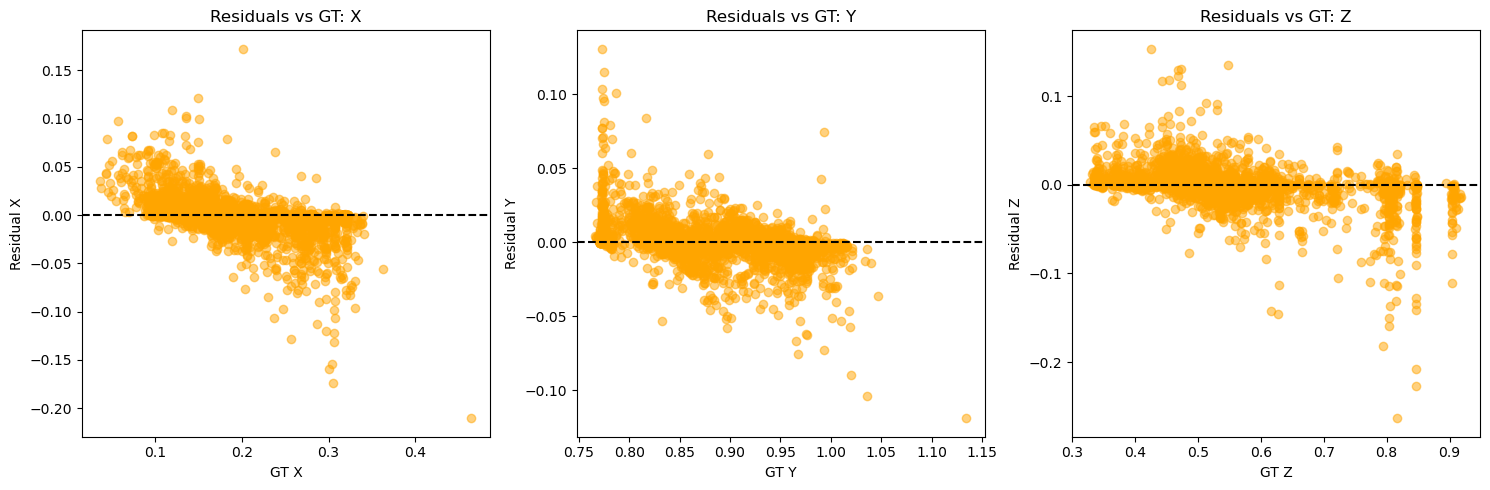

In [101]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, axis in enumerate(['X', 'Y', 'Z']):
    axes[i].scatter(y_test[f'GT_{axis}'], residuals_df[f'Residual_{axis}'], color='orange', alpha=0.5)
    axes[i].axhline(0, linestyle='--', color='black')
    axes[i].set_title(f'Residuals vs GT: {axis}')
    axes[i].set_xlabel(f'GT {axis}')
    axes[i].set_ylabel(f'Residual {axis}')
plt.tight_layout()
plt.show()

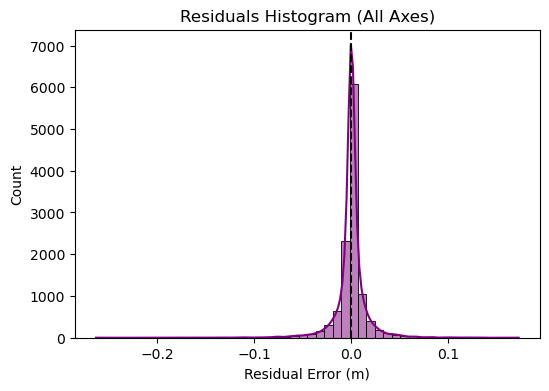

In [102]:
residuals_all = residuals_df.values.flatten()

plt.figure(figsize=(6, 4))
sns.histplot(residuals_all, bins=50, kde=True, color='purple')
plt.axvline(0, linestyle='--', color='black')
plt.title("Residuals Histogram (All Axes)")
plt.xlabel("Residual Error (m)")
plt.show()
